In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import os
os.chdir("..")

In [2]:
from deepsvg.svglib.svg import SVG

from deepsvg import utils
from deepsvg.difflib.tensor import SVGTensor
from deepsvg.svglib.utils import to_gif
from deepsvg.svglib.geom import Bbox
from deepsvg.svg_dataset import SVGDataset, load_dataset
from deepsvg.utils.utils import batchify, linear

import torch

# DeepSVG interpolation between pairs of icons

In [3]:
device = torch.device("cuda:0"if torch.cuda.is_available() else "cpu") 

Load the pretrained model and dataset

In [4]:
pretrained_path = "/home/i17oonaka/deepsvg/logs/models/deepsvg/hierarchical_ordered/best.pth.tar"
from configs.deepsvg.hierarchical_ordered import Config

cfg = Config()
model = cfg.make_model().to(device)
utils.load_model(pretrained_path, model)
model.eval();

In [5]:
dataset = load_dataset(cfg)

In [6]:
def easein_easeout(t):
    return t*t / (2. * (t*t - t) + 1.);

def interpolate_old(z1, z2, n=25, filename=None, ease=True, do_display=True):
    alphas = torch.linspace(0., 1., n)
    if ease:
        alphas = easein_easeout(alphas)
    z_list = [(1-a) * z1 + a * z2 for a in alphas]
    
    img_list = [decode(z, do_display=False, return_png=True) for z in z_list]
    to_gif(img_list + img_list[::-1], file_path=filename, frame_duration=1/12)

def interpolate(z_list, n=25, filename=None, ease=True, do_display=True):
    assert len(z_list) > 1, "Need at least 2 z's to interpolate"
    alphas = torch.linspace(0., 1., n)
    if ease:
        alphas = easein_easeout(alphas)
    z_decoded_list = []
    for i in range(len(z_list) - 1):
        z1 = z_list[i]
        z2 = z_list[i+1]
        for a in alphas:
            z_decoded_list.append((1-a) * z1 + a * z2)
    img_list = [decode(z, do_display=False, return_png=True) for z in z_decoded_list]
    to_gif(img_list + img_list[::-1], file_path=filename, frame_duration=1/12)

In [7]:
def encode_icon(idx):
    data = dataset.get(id=idx, random_aug=False)
    model_args = batchify((data[key] for key in cfg.model_args), device)
    with torch.no_grad():
        z = model(*model_args, encode_mode=True)
    return z

def decode(z, do_display=True, return_svg=False, return_png=False):
    commands_y, args_y = model.greedy_sample(z=z)
    tensor_pred = SVGTensor.from_cmd_args(commands_y[0].cpu(), args_y[0].cpu())
    svg_path_sample = SVG.from_tensor(tensor_pred.data, viewbox=Bbox(256), allow_empty=True).normalize().split_paths().set_color("gray")
    
    if return_svg:
        return svg_path_sample
    
    return svg_path_sample.draw(do_display=do_display, return_png=return_png)

In [8]:
def interpolate_icons_old(idx1=None, idx2=None, n=25, *args, **kwargs):
    z1, z2 = encode_icon(idx1), encode_icon(idx2)
    interpolate(z1, z2, n=n, *args, **kwargs)

def interpolate_icons(idx_list=None, n=25, *args, **kwargs):
    z_list = [encode_icon(idx) for idx in idx_list]
    interpolate(z_list, n=n, *args, **kwargs)

## Interpolation each hiraganas
Display an interpolation between random icons of the dataset!

In [9]:
import glob

svg_path = "/home/i17oonaka/deepsvg/deepsvg/hiragana/svg_simplefied_large"
hiraganas = [
        "あ", "い", "う", "え", "お",
        "か", "き", "く", "け", "こ",
        "さ", "し", "す", "せ", "そ",
        "た", "ち", "つ", "て", "と",
        "な", "に", "ぬ", "ね", "の",
        "は", "ひ", "ふ", "へ", "ほ",
        "ま", "み", "む", "め", "も",
        "や", "ゆ", "よ",
        "ら", "り", "る", "れ", "ろ",
        "わ", "を", "ん",
        "が", "ぎ", "ぐ", "げ", "ご",
        "ざ", "じ", "ず", "ぜ", "ぞ",
        "だ", "ぢ", "づ", "で", "ど",
        "ば", "び", "ぶ", "べ", "ぼ",
        "ぱ", "ぴ", "ぷ", "ぺ", "ぽ",
        "ゃ", "ゅ", "ょ",
        "っ",
        "ぁ", "ぃ", "ぅ", "ぇ", "ぉ",
    ]
# seek [hiragana_id]_[hiragana]_361_***.svg
list_randomselect = []
for hira_id, hiragana in enumerate(hiraganas):
    df = dataset.df
    # random select one svg in each hiragana
    df = df[df["id"].str.contains(str(hira_id)+"_"+hiragana)]
    df = df.sample(n=1)
    list_randomselect.append(df)


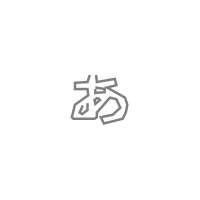

In [10]:
# interpolate all selected svg
z_list = []
for df in list_randomselect:
    data = dataset.get(id=df["id"].values[0], random_aug=False)
    model_args = batchify((data[key] for key in cfg.model_args), device)
    with torch.no_grad():
        z = model(*model_args, encode_mode=True)
    z_list.append(z)
interpolate(z_list, n=10, filename="hiragana_interpolate2.gif", ease=False)